In [ ]:
from morl_module import *

# Evaluación

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import os
from typing import List, Type
from datetime import timedelta
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize


In [ ]:

    model_paths_PPO = {
      "PPO-mm-linear": "models/ppo/minmax-linear/best/best_model.zip",
      "PPO-product": "models/ppo/product/best/best_model.zip",
      "PPO-chebyshev": "models/ppo/chebyshev/best/best_model.zip",
      "PPO-soft-penalty": "models/ppo/soft-penalty/best/best_model.zip",
      "PPO-uniobjetivo": "models/ppo/uniobjetivo/minmax-linear/best/best_model.zip",
    }

    model_paths_A2C = {
      "A2C-mm-linear": "models/a2c/minmax-linear/best/best_model.zip",
      "A2C-product": "models/a2c/product/best/best_model.zip",
      "A2C-chebyshev": "models/a2c/chebyshev/best/best_model.zip",
      "A2C-soft-penalty": "models/a2c/soft-penalty/best/best_model.zip",
      "A2C-uniobjetivo": "models/a2c/uniobjetivo/minmax-linear/best/best_model.zip",
    }

    norm_paths_PPO = {
      "PPO-mm-linear": "models/ppo/minmax-linear/vecnorm.pkl",
      "PPO-product": "models/ppo/product/vecnorm.pkl",
      "PPO-chebyshev": "models/ppo/chebyshev/vecnorm.pkl",
      "PPO-soft-penalty": "models/ppo/soft-penalty/vecnorm.pkl",
      "PPO-uniobjetivo": "models/ppo/uniobjetivo/minmax-linear/vecnorm.pkl",
    }

    norm_paths_A2C = {
      "A2C-mm-linear": "models/a2c/minmax-linear/vecnorm.pkl",
      "A2C-product": "models/a2c/product/vecnorm.pkl",
      "A2C-chebyshev": "models/a2c/chebyshev/vecnorm.pkl",
      "A2C-soft-penalty": "models/a2c/soft-penalty/vecnorm.pkl",
      "A2C-uniobjetivo": "models/a2c/uniobjetivo/minmax-linear/vecnorm.pkl",
    }

    method_map_PPO = {
        "PPO-mm-linear":   "minmax-linear",
        "PPO-product":     "product",
        "PPO-chebyshev":   "chebyshev",
        "PPO-soft-penalty":"soft-penalty",
        "PPO-uniobjetivo":     "minmax-linear",
    }

    method_map = {
        "A2C-mm-linear":   "minmax-linear",
        "A2C-product":     "product",
        "A2C-chebyshev":   "chebyshev",
        "A2C-soft-penalty":"soft-penalty",
        "A2C-uniobjetivo":     "minmax-linear",
    }


    model_paths_LONG = {
      "PPO-product": "models/ppo/product/best/best_model.zip",
      "PPO-long-product": "models/ppo/long-product/best/best_model.zip",
      "A2C-mm-linear": "models/a2c/minmax-linear/best/best_model.zip",
      "A2C-long-mm-linear": "models/a2c/long-minmax-linear/best/best_model.zip",
    }

    norm_paths_LONG = {
      "PPO-product": "models/ppo/product/vecnorm.pkl",
      "PPO-long-product": "models/ppo/long-product/vecnorm.pkl",
      "A2C-mm-linear": "models/a2c/minmax-linear/vecnorm.pkl",
      "A2C-long-mm-linear": "models/a2c/long-minmax-linear/vecnorm.pkl",

    }

    method_map_LONG = {
        "PPO-product":     "product",
        "PPO-long-product":     "product",
        "A2C-mm-linear":   "minmax-linear",
        "A2C-long-mm-linear":   "minmax-linear",
    }

In [ ]:
# Comparativa de modelos
if __name__ == "__main__":

    TITLE_FS = 24
    LABEL_FS = 20
    TICK_FS = 20
    LEGEND_FS= 16

    data_files = {
        "3": "data/datos_3.csv",
        "1": "data/datos_1.csv",
        "2": "data/datos_2.csv",
    }
    agent_families = {
        "PPO": (model_paths_PPO, norm_paths_PPO, method_map_PPO, PPO),
        "A2C": (model_paths_A2C, norm_paths_A2C, method_map_A2C, A2C),
        "LONG": (model_paths_LONG, norm_paths_LONG, method_map_LONG, LONG),
    }
    periods = {
        "baj": ("2022-01-01", "2022-06-30"),
        "alc": ("2024-01-01", "2024-06-30"),
    }
    fam_name = "LONG"
    model_paths = model_paths_LONG
    norm_paths = norm_paths_LONG
    method_map = method_map_LONG

    out_dir = "imagenes"
    os.makedirs(out_dir, exist_ok=True)

    for grupo, file in data_files.items():

        # Carga de datos
        df_full = pd.read_csv(file, parse_dates=["date"], index_col="date")
        for per_name, (ini_date, end_date) in periods.items():
            df_test = load_price_data(ini_date, end_date, 5, df_full.reset_index())
            tickers = [c.split("_")[-1] for c in df_test.filter(regex="^adj_close_").columns]

            # ---Gráfico de lineas y de barras y métricas---
            results, metrics = {}, {}

            for name, path in model_paths.items():
                if name.startswith("PPO"):
                    model = PPO.load(path)
                else:
                    model = A2C.load(path)

                model = AgentCls.load(path)
                method = method_map[name]
                fixed_w = np.array([1.,0,0]) if "uniobjetivo" in name else None
                vec_env = make_normalized_env(
                    df_test, tickers, method,
                    norm_path=norm_paths[name],
                    max_len=None,
                    random_start=False,
                    fixed_w=fixed_w
                )
                df_d, m = evaluate_agent_backtest(model, vec_env, df_test, tickers)
                results[name] = df_d["portfolio_value"]
                metrics[name] = m
                vec_env.close()

            # Buy & hold
            df_bh, m_bh = backtest_buy_and_hold(df_test, tickers)
            results["BuyHold"] = df_bh["portfolio_value"]
            metrics["BuyHold"] = m_bh

            # ETFs
            etf_tks = ["DSI","SUSA","EFIV"]
            df_etfs, mets_etf = backtest_etfs(etf_tks, ini_date, end_date)
            for tk in etf_tks:
                results[f"ETF_{tk}"] = df_etfs[tk]
                metrics[f"ETF_{tk}"] = mets_etf[tk]

            # limpieza y df_all
            cleaned = {}
            for nm, met in metrics.items():
                if isinstance(met, dict):
                    clean = {}
                    for k,v in met.items():
                        clean[k] = v.iloc[0] if isinstance(v, pd.Series) else v
                    cleaned[nm] = clean
                else:
                    cleaned[nm] = met
            df_all = pd.DataFrame.from_dict(cleaned, orient="index")

            # colores
            agent_keys = [k for k in metrics if not k.startswith("ETF_") and k!="BuyHold"]
            cmap = plt.get_cmap("tab10")
            agent_colors = {agent_keys[i]: cmap(i) for i in range(len(agent_keys))}
            agent_colors["BuyHold"] = "black"
            for tk in [k for k in metrics if k.startswith("ETF_")]:
                agent_colors[tk] = "black"
            light_gray = "#d3d3d3"

            # Gráficos de lineas y barras
            TITLE_FS = 24
            LABEL_FS = 20
            TICK_FS = 20
            LEGEND_FS= 16
            fig = plt.figure(constrained_layout=True, figsize=(14,10))
            gs = fig.add_gridspec(2,3, height_ratios=[2,1])
            ax0 = fig.add_subplot(gs[0,:])
            etf_styles = {"ETF_DSI":"--","ETF_SUSA":"-.","ETF_EFIV":":"}
            for lbl, series in results.items():
                if lbl.startswith("ETF_"):
                    lw,ls,c = 1, etf_styles.get(lbl,"--"), "black"
                elif lbl=="BuyHold":
                    lw,ls,c = 2,"-","black"
                else:
                    lw,ls,c = 2,"-", agent_colors[lbl]
                ax0.plot(series.index, series.values, lw=lw, ls=ls, color=c, label=lbl)
            ax0.set_title("Evolución de cartera",fontsize=TITLE_FS)
            ax0.set_ylabel("Valor ($)",fontsize=LABEL_FS)
            ax0.tick_params(labelsize=TICK_FS)
            ax0.grid(True)
            ax0.legend(ncol=2,fontsize=LEGEND_FS)

            # Barras
            metrics_to_plot=[("ROI","Retorno total (%)"),("Vol_Ann","Vol anual (%)"),("avg_esg","ESG medio")]
            labels = df_all.index.tolist()
            x = np.arange(len(labels))
            for i,(met,ylabel) in enumerate(metrics_to_plot):
                ax = fig.add_subplot(gs[1,i])
                vals = df_all[met]
                bhv = df_all.loc["BuyHold",met]
                cols=[]
                for l in labels:
                    if l=="BuyHold" or l.startswith("ETF_"):
                        cols.append(agent_colors[l])
                    else:
                        hl = (vals[l]<bhv) if met=="Vol_Ann" else (vals[l]>bhv)
                        cols.append(agent_colors[l] if hl else light_gray)
                ax.bar(x, vals, color=cols, width=0.6)
                ax.set_title(ylabel,fontsize=TITLE_FS)
                ax.set_xticks(x); ax.set_xticklabels(labels,rotation=45,ha="right",fontsize=TICK_FS)
                ax.tick_params(axis="y",labelsize=TICK_FS)
                ax.grid(axis="y",linestyle="--",alpha=0.6)

            fname = f"{fam_name}_{grupo}_{per_name}_lineas.png"
            fig.savefig(os.path.join(out_dir, fname), dpi=200)
            plt.close(fig)

            # Violines
            metrics_hist = evaluate_robustness(
                model_paths, norm_paths, method_map,
                df_test, tickers, n_runs=50
            )
            fig_violin = plot_violin_metrics(
                metrics_hist,
                list(model_paths.keys()),
                agent_colors
            )
            fname2 = f"{fam_name}_{grupo}_{per_name}_violines.png"
            fig_violin.savefig(os.path.join(out_dir, fname2), dpi=200)
            plt.close(fig_violin)


            # Tablas
            print("\n— Comparativa de métricas —\n")
            df_fmt = df_all.copy()
            pct_cols = ["ROI","CAGR","Vol_Ann","Max_Drwdwn","avg_dly_ret","avg_dly_vol"]
            df_fmt[pct_cols] = (df_fmt[pct_cols]*100).round(3).astype(str)+"%"
            df_fmt["Sharpe"] = df_fmt["Sharpe"].round(3).astype(str)
            df_fmt["final_value"] = df_fmt["final_value"].round(3).astype(str)
            df_fmt["avg_esg"] = df_fmt["avg_esg"].round(3).astype(str)
            df_fmt["total_trads"] = df_fmt["total_trads"].astype(str)
            print(df_fmt)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Evaluando robustez de PPO-product...
Evaluando robustez de PPO-long-product...
Evaluando robustez de A2C-mm-linear...
Evaluando robustez de A2C-long-mm-linear...

— Comparativa de métricas —

                         ROI      CAGR  Vol_Ann  Sharpe Max_Drwdwn  \
PPO-product         -13.047%  -25.047%  40.683%   0.199   -29.228%   
PPO-long-product    -28.459%  -49.873%  65.417%   0.275   -30.872%   
A2C-mm-linear       -21.757%  -39.706%  57.535%   0.265   -33.137%   
A2C-long-mm-linear  -27.525%  -48.515%  63.275%   0.269   -28.761%   
BuyHold             -12.204%  -23.425%  27.595%   -0.82   -18.364%   
ETF_DSI             -21.839%  -39.837%  26.692%  -1.772   -25.069%   
ETF_SUSA            -22.957%  -41.598%  25.987%  -1.942   -26.153%   
ETF_EFIV            -19.145%  -35.482%  25.074%  -1.624   -22.495%   

                   final_value avg_dly_ret avg_dly_vol avg_esg total_trads  
PPO-product         869525.265      0.032%      2.563%   0.673        1127  
PPO-long-product    715

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Evaluando robustez de PPO-product...
Evaluando robustez de PPO-long-product...
Evaluando robustez de A2C-mm-linear...
Evaluando robustez de A2C-long-mm-linear...

— Comparativa de métricas —

                        ROI     CAGR  Vol_Ann Sharpe Max_Drwdwn  final_value  \
PPO-product           6.75%   14.42%  21.968%   0.11   -10.185%  1067504.025   
PPO-long-product     7.858%  16.882%  22.082%  0.111   -10.414%   1078582.43   
A2C-mm-linear        7.077%  15.144%  23.195%  0.116   -11.038%  1070774.632   
A2C-long-mm-linear   0.738%   1.528%  17.699%  0.088   -12.765%  1007378.743   
BuyHold              4.172%   8.742%  12.151%  0.744    -4.853%  1041717.879   
ETF_DSI             15.315%  33.938%  12.042%  2.486    -6.487%  1153151.989   
ETF_SUSA            13.199%  28.946%  10.953%  2.375    -6.192%  1131991.035   
ETF_EFIV             16.47%  36.703%  10.825%  2.941    -5.499%  1164703.325   

                   avg_dly_ret avg_dly_vol avg_esg total_trads  
PPO-product           

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Evaluando robustez de PPO-product...
Evaluando robustez de PPO-long-product...
Evaluando robustez de A2C-mm-linear...
Evaluando robustez de A2C-long-mm-linear...

— Comparativa de métricas —

                         ROI      CAGR  Vol_Ann  Sharpe Max_Drwdwn  \
PPO-product          18.613%    42.19%  35.079%   0.183   -17.384%   
PPO-long-product     -7.917%  -15.642%  27.269%   0.134   -11.998%   
A2C-mm-linear         6.886%   14.721%  26.129%    0.13   -16.697%   
A2C-long-mm-linear  -16.005%  -30.208%  41.822%   0.198   -19.943%   
BuyHold              -0.467%   -0.955%  23.851%   0.079   -13.778%   
ETF_DSI             -21.839%  -39.837%  26.692%  -1.772   -25.069%   
ETF_SUSA            -22.957%  -41.598%  25.987%  -1.942   -26.153%   
ETF_EFIV            -19.145%  -35.482%  25.074%  -1.624   -22.495%   

                    final_value avg_dly_ret avg_dly_vol avg_esg total_trads  
PPO-product         1186126.253      0.025%       2.21%   0.698        1124  
PPO-long-product     

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Evaluando robustez de PPO-product...
Evaluando robustez de PPO-long-product...
Evaluando robustez de A2C-mm-linear...
Evaluando robustez de A2C-long-mm-linear...

— Comparativa de métricas —

                        ROI     CAGR  Vol_Ann Sharpe Max_Drwdwn  final_value  \
PPO-product         19.834%  45.227%  26.492%  0.145    -4.247%  1198343.504   
PPO-long-product    30.932%  74.327%  40.299%  0.227   -11.085%  1309319.787   
A2C-mm-linear       14.237%  31.586%  21.364%  0.113    -4.163%  1142373.712   
A2C-long-mm-linear   1.544%    3.21%  18.864%  0.095   -13.016%  1015438.882   
BuyHold             23.832%  55.009%  10.425%  4.222    -3.067%  1238315.081   
ETF_DSI             15.315%  33.938%  12.042%  2.486    -6.487%  1153151.989   
ETF_SUSA            13.199%  28.946%  10.953%  2.375    -6.192%  1131991.035   
ETF_EFIV             16.47%  36.703%  10.825%  2.941    -5.499%  1164703.325   

                   avg_dly_ret avg_dly_vol avg_esg total_trads  
PPO-product           

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Evaluando robustez de PPO-product...
Evaluando robustez de PPO-long-product...
Evaluando robustez de A2C-mm-linear...
Evaluando robustez de A2C-long-mm-linear...

— Comparativa de métricas —

                         ROI      CAGR  Vol_Ann  Sharpe Max_Drwdwn  \
PPO-product            3.79%    7.972%   22.46%   0.112   -15.514%   
PPO-long-product     -0.873%   -1.791%  20.897%   0.104   -12.468%   
A2C-mm-linear        -3.501%   -7.085%  21.797%   0.108   -16.278%   
A2C-long-mm-linear  -20.528%  -37.737%  48.283%    0.22   -21.118%   
BuyHold              -7.427%  -14.637%  23.463%  -0.551   -14.652%   
ETF_DSI             -21.839%  -39.837%  26.692%  -1.772   -25.069%   
ETF_SUSA            -22.957%  -41.598%  25.987%  -1.942   -26.153%   
ETF_EFIV            -19.145%  -35.482%  25.074%  -1.624   -22.495%   

                   final_value avg_dly_ret avg_dly_vol avg_esg total_trads  
PPO-product         1037895.02       0.01%      1.415%   0.686        1148  
PPO-long-product    991

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Evaluando robustez de PPO-product...
Evaluando robustez de PPO-long-product...
Evaluando robustez de A2C-mm-linear...
Evaluando robustez de A2C-long-mm-linear...

— Comparativa de métricas —

                        ROI     CAGR  Vol_Ann Sharpe Max_Drwdwn  final_value  \
PPO-product         12.534%  27.573%  20.146%  0.105    -3.741%  1125343.897   
PPO-long-product    15.498%  34.598%  23.777%  0.126    -5.227%  1154980.913   
A2C-mm-linear       -1.232%  -2.524%  12.675%  0.063    -5.199%   987681.009   
A2C-long-mm-linear  10.277%  22.352%  23.979%  0.122   -11.664%  1102771.299   
BuyHold              9.747%  21.013%  11.952%  1.641    -6.369%  1097473.486   
ETF_DSI             15.315%  33.938%  12.042%  2.486    -6.487%  1153151.989   
ETF_SUSA            13.199%  28.946%  10.953%  2.375    -6.192%  1131991.035   
ETF_EFIV             16.47%  36.703%  10.825%  2.941    -5.499%  1164703.325   

                   avg_dly_ret avg_dly_vol avg_esg total_trads  
PPO-product           

In [ ]:
# Comparativa manual

if __name__ == "__main__":
    ini_date_bajista = "2022-01-01"
    end_date_bajista = "2022-06-30"
    ini_date_alcista = "2024-01-01"
    end_date_alcista = "2024-06-30"

    # datos y particiones
    df_full = pd.read_csv("data/datos_3.csv", parse_dates=["date"], index_col="date")
    df_test = load_price_data(ini_date, end_date , 5, df_full.reset_index())
    tickers = [c.split("_")[-1] for c in df_test.filter(regex="^adj_close_").columns]

    results, metrics = {}, {}
    for name in model_paths:
        model = PPO.load(model_paths[name])
        method = method_map[name]
        if "uniobjetivo" in name:
            vec_env = make_normalized_env(
                df_test,
                tickers,
                method=method,
                norm_path=norm_paths[name],
                max_len=None,
                random_start=False,
                fixed_w=np.array([1.0, 0.0, 0.0])
            )
        else:
            vec_env = make_normalized_env(
                df_test,
                tickers,
                method=method,
                norm_path=norm_paths[name],
                max_len=None,
                random_start=False
            )
        # evaluación
        df_d, m = evaluate_agent_backtest(model, vec_env, df_test, tickers)
        results[name] = df_d["portfolio_value"]
        metrics[name] = m

    # Buy & hold
    df_bh, m_bh = backtest_buy_and_hold(df_test, tickers)
    results["BuyHold"] = df_bh["portfolio_value"]
    metrics["BuyHold"] = m_bh

    # ETFs benchmark
    etf_tks = ["DSI","SUSA","EFIV"]
    df_etfs, mets_etf = backtest_etfs(etf_tks, ini_date, end_date)
    for tk in etf_tks:
        results[f"ETF_{tk}"] = df_etfs[tk]
        metrics[f"ETF_{tk}"] = mets_etf[tk]

    # Tabla de métricas
    cleaned = {}
    for name, met in metrics.items():
        if isinstance(met, dict):
            clean_met = {}
            for k, v in met.items():
                if isinstance(v, pd.Series):
                    clean_met[k] = v.iloc[0]
                else:
                    clean_met[k] = v
            cleaned[name] = clean_met
        else:
            cleaned[name] = met

    df_all = pd.DataFrame.from_dict(cleaned, orient="index")

    labels = df_all.index.tolist()
    x = np.arange(len(labels))

    agent_keys = [k for k in metrics.keys() if not k.startswith("ETF_") and k != "BuyHold"]
    cmap = plt.get_cmap("tab10")

    agent_colors = {agent_keys[i]: cmap(i) for i in range(len(agent_keys))}
    agent_colors["BuyHold"] = "black"
    etf_linestyles = {"ETF_DSI": "--", "ETF_SUSA": "-.", "ETF_EFIV": ":"}
    for etf in [k for k in metrics if k.startswith("ETF_")]:
        agent_colors[etf] = "black"

    light_gray = "#d3d3d3"

    TITLE_FS = 24
    LABEL_FS = 20
    TICK_FS = 16
    LEGEND_FS= 16

    fig = plt.figure(constrained_layout=True, figsize=(14, 10))
    gs = fig.add_gridspec(2, 3, height_ratios=[2, 1])

    # Gráfico de líneas
    ax0 = fig.add_subplot(gs[0, :])
    for label, series in results.items():
        if label.startswith("ETF_"):
            lw, ls, c = 1, etf_linestyles.get(label, "--"), "black"
        elif label == "BuyHold":
            lw, ls, c = 2, "-", "black"
        else:
            lw, ls, c = 2, "-", agent_colors[label]
        ax0.plot(series.index, series.values,
                label=label,
                linewidth=lw, linestyle=ls, color=c)

    ax0.set_title("Evolución de cartera", fontsize=TITLE_FS)
    ax0.set_ylabel("Valor ($)",           fontsize=LABEL_FS)
    ax0.tick_params(axis='both', labelsize=TICK_FS)

    ax0.legend(ncol=2, fontsize=LEGEND_FS)
    ax0.grid(True)

    # Gráficos de barras
    metrics_to_plot = [
        ("ROI", "Retorno total (%)"),
        ("Vol_Ann", "Volatilidad anual (%)"),
        ("avg_esg", "ESG medio")
    ]
    for i, (metric, ylabel) in enumerate(metrics_to_plot):
        ax = fig.add_subplot(gs[1, i])
        vals = df_all[metric]
        bh_val = df_all.loc["BuyHold", metric]
        colors = []
        for lbl in labels:
            if lbl == "BuyHold" or lbl.startswith("ETF_"):
                colors.append(agent_colors[lbl])
            else:
                if metric == "Vol_Ann":
                    highlight = vals[lbl] < bh_val
                else:
                    highlight = vals[lbl] > bh_val
                colors.append(agent_colors[lbl] if highlight else light_gray)

        ax.bar(x, vals, color=colors, width=0.6)
        ax.set_title(ylabel,        fontsize=TITLE_FS)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=TICK_FS)
        ax.tick_params(axis='y', labelsize=TICK_FS)
        ax.grid(axis="y", linestyle="--", alpha=0.6)

    plt.show()

    metrics_hist = evaluate_robustness(
        model_paths=model_paths,
        norm_paths=norm_paths,
        method_map=method_map,
        df=df_test,
        tickers=tickers,
        n_runs=50
    )

    plot_violin_metrics(
        metrics_hist,
        list(model_paths.keys()),
        agent_colors
    )

    # Tabla formateada
    df_fmt = df_all.copy()
    pct_cols = ["ROI", "CAGR", "Vol_Ann", "Max_Drwdwn", "avg_dly_ret", "avg_dly_vol"]
    df_fmt[pct_cols] = (df_fmt[pct_cols] * 100).round(3).astype(str) + '%'
    df_fmt["Sharpe"] = df_fmt["Sharpe"].round(3).astype(str)
    df_fmt["final_value"] = df_fmt["final_value"].round(3).astype(str)
    df_fmt["avg_esg"] = df_fmt["avg_esg"].round(3).astype(str)
    df_fmt["total_trads"] = df_fmt["total_trads"].astype(str)

    print("\n— Comparativa de métricas —\n")
    print(df_fmt)


# El frente de Pareto

In [ ]:

    model_paths_LONG = {
      "PPO-product": "models/ppo/product/best/best_model.zip",
      "PPO-long-product": "models/ppo/long-product/best/best_model.zip",
      "A2C-mm-linear": "models/a2c/minmax-linear/best/best_model.zip",
      "A2C-long-mm-linear": "models/a2c/long-minmax-linear/best/best_model.zip",
    }

    norm_paths_LONG = {
      "PPO-product": "models/ppo/product/vecnorm.pkl",
      "PPO-long-product": "models/ppo/long-product/vecnorm.pkl",
      "A2C-mm-linear": "models/a2c/minmax-linear/vecnorm.pkl",
      "A2C-long-mm-linear": "models/a2c/long-minmax-linear/vecnorm.pkl",

    }

    method_map_LONG = {
        "PPO-product":     "product",
        "PPO-long-product":     "product",
        "A2C-mm-linear":   "minmax-linear",
        "A2C-long-mm-linear":   "minmax-linear",
    }

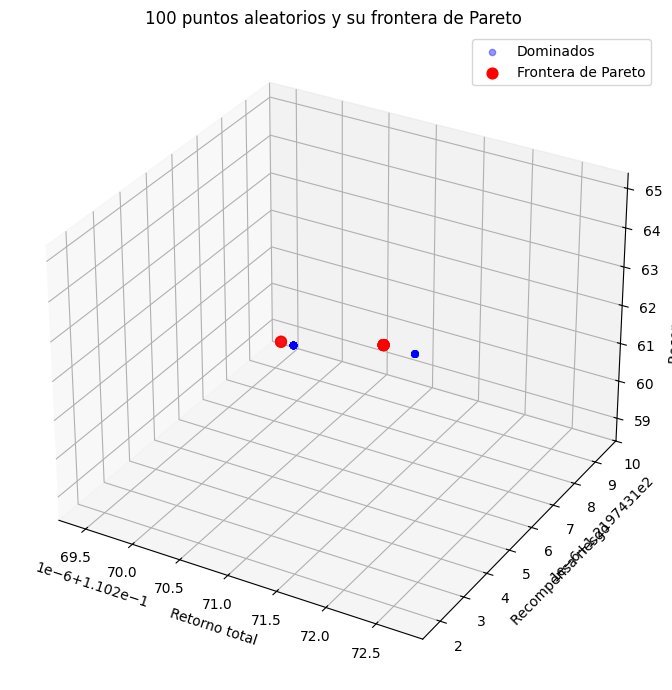

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize

if __name__ == "__main__":
    # Carga de datos y modelo
    df_full = pd.read_csv("data/datos_3.csv", parse_dates=["date"])
    df_test = load_price_data("2024-01-01", "2024-06-30", 5, df_full)
    tickers = [c.split("_")[-1] for c in df_test.filter(regex="^adj_close_").columns]

    model = PPO.load("models/ppo/chebyshev/best/best_model.zip")
    vecnorm = "models/ppo/chebyshev/vecnorm.pkl"

    method = "chebyshev"

    # Recopilar puntos de 100 w aleatorios y máscara
    np.random.seed(0)
    ws = [np.random.dirichlet(np.ones(3)).astype(np.float32) for _ in range(100)]

    results = collect_pareto_points(model, df_test, tickers, vecnorm, method, ws)

    W_arr = np.vstack([w for w,_ in results])
    V_arr = np.vstack([v for _,v in results])
    mask = is_pareto(V_arr)

    # visualizacion
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(V_arr[~mask,0], V_arr[~mask,1], V_arr[~mask,2],
               c='blue', alpha=0.4, label='Dominados')
    ax.scatter(V_arr[mask, 0], V_arr[mask, 1], V_arr[mask, 2],
               c='red',   s=60,  label='Frontera de Pareto')
    ax.set_xlabel("Retorno total")
    ax.set_ylabel("Recompensa riesgo")
    ax.set_zlabel("Recompensa ESG")
    ax.set_title("100 puntos aleatorios y su frontera de Pareto")
    ax.legend()
    plt.tight_layout()
    plt.show()
